In [1]:
import numpy as np
from matplotlib import pyplot as plt


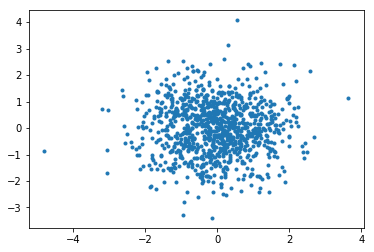

In [2]:
from scipy.stats import multivariate_normal

def gen_correlated_sample(rho = 0, n = 1000):
    cov = np.array([[1, rho], [rho, 1]])
    x = []
    y = []
    return multivariate_normal.rvs([0, 0], cov, 1000).T

data = gen_correlated_sample(rho = 0, n = 1000)
plt.scatter(data[0], data[1], marker = ".")
plt.show()

In [3]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
import math

np.warnings.filterwarnings('ignore')

def rf_entropy_estimate_bagging(X, y, n_estimators = 500, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 5):
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    model = BaggingRegressor(DecisionTreeRegressor(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = int(math.ceil(X.shape[1]/3))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    posterior_counts = [[] for _ in range(len(X))]
    for tree_idx in range(n_estimators):
        tree = model[tree_idx]
        unsampled_indices = np.where(model.estimators_samples_[tree_idx] == False)[0]
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        node_counts = tree.tree_.n_node_samples
        leaf_elems = [[] for _ in range(len(node_counts))]
        for prob_index in prob_indices:
            leaf_elems[tree.apply(X[prob_index].reshape(1, -1)).item()].append(y[prob_index])
        for eval_index in eval_indices:
            # for every x, collect all y samples in the leaf nodes x fell into (for entire forest)
            posterior_counts[eval_index].extend(leaf_elems[tree.apply(X[eval_index].reshape(1, -1)).item()])
    # for every x, approximate histogram entropy
    entropy_estimates = []
    for elem in posterior_counts:
        elem.sort()
        entropy = 0.
        hist = np.histogram(elem, bins = "auto")
        pdf = hist[0]/len(elem)
        for i in range(len(pdf)):
            incr = -pdf[i]*np.log(pdf[i]/(hist[1][i + 1] - hist[1][i]))
            if not np.isnan(incr) and incr >= 0:
                entropy += incr
        entropy_estimates.append(entropy)
    return np.mean(entropy_estimates)


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [46]:
x, y = gen_correlated_sample(rho = 1., n = 1000)
rf_entropy_estimate_bagging(x, y)

0.04692502891981168

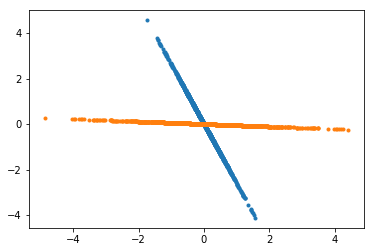

In [4]:
from scipy.ndimage import rotate

def rotate_data(matrix, angle = 0):
    R = np.array([[math.cos(angle), -math.sin(angle)], [math.sin(angle), math.cos(angle)]])
    rotated_matrix = np.matmul(R, matrix)
    return rotated_matrix

x = gen_correlated_sample(rho = 1., n = 1000)
x_rot = rotate_data(x, angle = 20)
plt.scatter(x_rot[0], x_rot[1], marker = ".")
x_rot_2 = rotate_data(x, angle = 40)
plt.scatter(x_rot_2[0], x_rot_2[1], marker = ".")

plt.show()

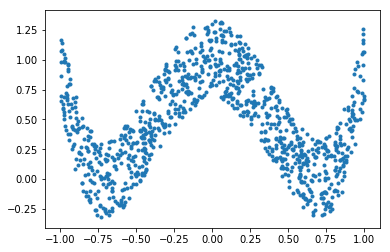

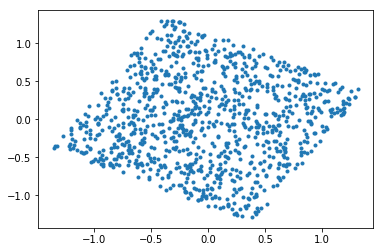

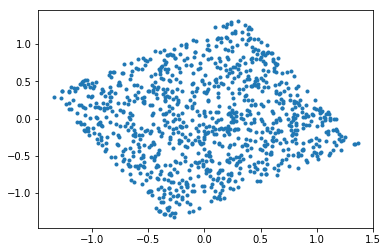

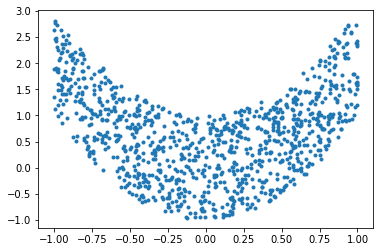

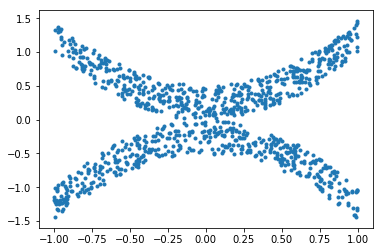

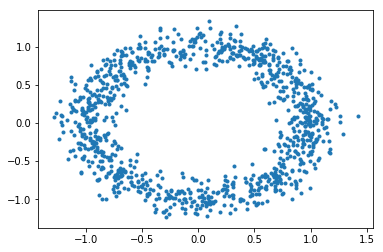

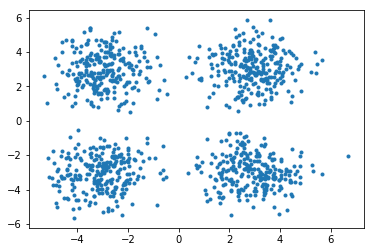

In [5]:
def others(n = 1000):
    settings = []
    x = np.random.uniform(-1, 1, n)
    y = 4 * (x**2 - 1/2)**2 + np.random.uniform(-1, 1, n)/3
    settings.append(np.array((x, y)))
    
    y = np.random.uniform(-1, 1, n)
    xy = rotate_data(np.array((x, y)), angle = -22.5)
    settings.append(xy)
    settings.append(rotate_data(xy, angle = -22.5))
    
    y = 2*x**2 + np.random.uniform(-1, 1, n)
    settings.append(np.array((x, y)))
    signs = np.random.randint(2, size=n)
    signs[signs == 0] = -1
    y = (x**2 + np.random.uniform(0, .5, n)) * signs
    settings.append(np.array((x, y)))
    
    y = np.cos(x*math.pi) + np.random.normal(0, 1/8, n)
    x = np.sin(x*math.pi) + np.random.normal(0, 1/8, n)
    settings.append(np.array((x, y)))
    
    xy1 = multivariate_normal.rvs([3, 3], np.identity(2), n//4)
    xy2 = multivariate_normal.rvs([-3, 3], np.identity(2), n//4)
    xy3 = multivariate_normal.rvs([-3, -3], np.identity(2), n//4)
    xy4 = multivariate_normal.rvs([3, -3], np.identity(2), n//4)
    settings.append(np.concatenate((xy1, xy2, xy3, xy4), axis = 0).T)
    return settings
settings = others()
plt.scatter(settings[0][0], settings[0][1], marker = ".")
plt.show()
plt.scatter(settings[1][0], settings[1][1], marker = ".")
plt.show()
plt.scatter(settings[2][0], settings[2][1], marker = ".")
plt.show()
plt.scatter(settings[3][0], settings[3][1], marker = ".")
plt.show()
plt.scatter(settings[4][0], settings[4][1], marker = ".")
plt.show()
plt.scatter(settings[5][0], settings[5][1], marker = ".")
plt.show()
plt.scatter(settings[6][0], settings[6][1], marker = ".")
plt.show()

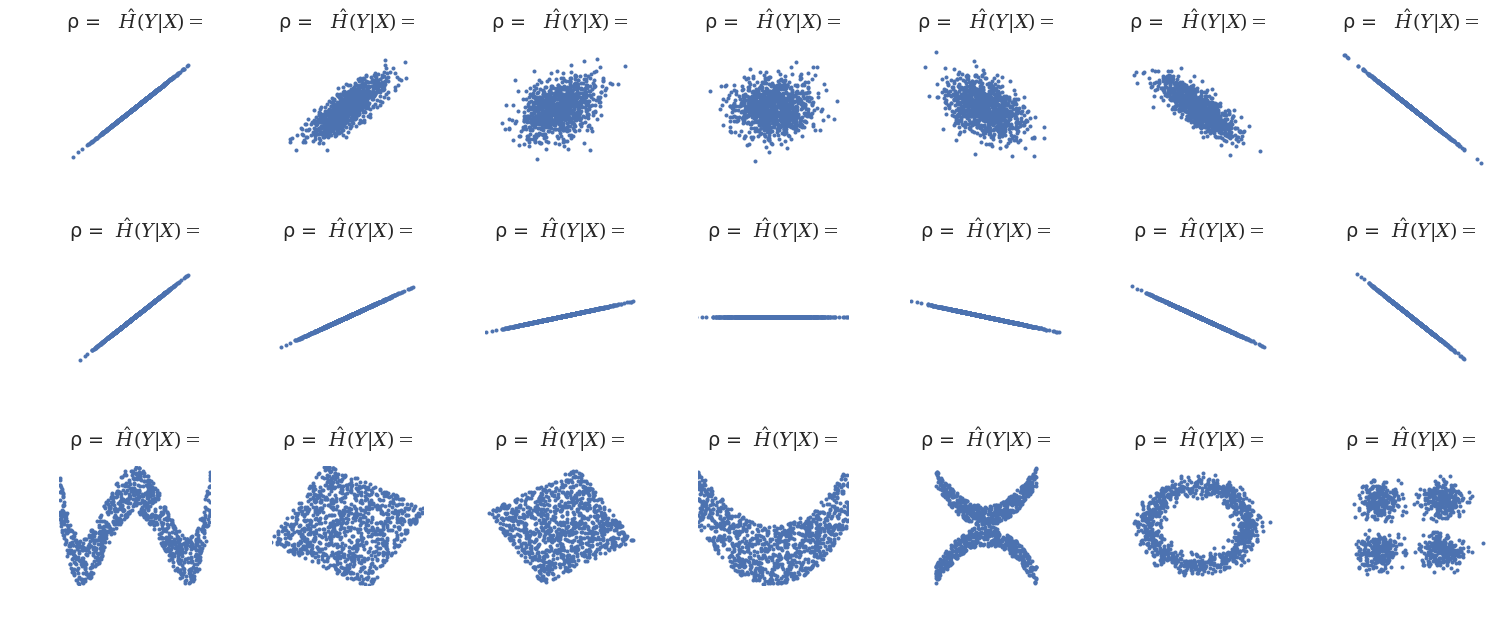

In [13]:
import seaborn as sns
from tqdm import tqdm_notebook
sns.set(font_scale = 1.6)
sns.set_style("ticks")
plt.rcParams["font.family"] = "dejavuserif"
plt.rcParams['mathtext.fontset'] = "dejavuserif"
plt.rcParams['axes.titlepad'] = 20 

f, axar = plt.subplots(3, 7, figsize=(21, 9))
rhos = [1, 0.8, 0.4, 0, -0.4, -0.8, -1]
lim = math.sqrt(2+ math.sqrt(2))/math.sqrt(2)
x_ranges = ([-1, 1], [-lim, lim], [-math.sqrt(2), math.sqrt(2)], [-1, 1], [-1.5, 1.5], [-1.5, 1.5], [-7, 7])
y_ranges = ([-1/3, 1 + 1/3], [-lim, lim], [-math.sqrt(2), math.sqrt(2)], [-1, 3], [-1.5, 1.5], [-1.5, 1.5], [-7, 7])
for j in range(7):
    data = gen_correlated_sample(rho = rhos[j], n = 1000)
    axar[0, j].set_title(u"\u03C1 =  "+ r" $\hat H(Y|X) = $")
    axar[0, j].scatter(data[0], data[1], marker = ".", color = "b")
    axar[0, j].axis('off')
    axar[0, j].set_xlim([-4, 4])
    axar[0, j].set_ylim([-4, 4])

angles = [0, -math.pi/12, -math.pi/6, -math.pi/4, -math.pi/2+math.pi/6, -math.pi/2+math.pi/12, -math.pi/2]
data = gen_correlated_sample(rho = 1., n = 1000)
for j in range(7):
    data_rot = rotate_data(data, angle = angles[j])
    axar[1, j].set_title(u"\u03C1 =  " + r"$\hat H(Y|X) = $")
    axar[1, j].scatter(data_rot[0], data_rot[1], marker = ".", color = "b")
    axar[1, j].axis('off')
    axar[1, j].set_xlim([-4, 4])
    axar[1, j].set_ylim([-4, 4])
for j in range(7):
    
    axar[2, j].set_title(u"\u03C1 =  " + r"$\hat H(Y|X) = $")
    axar[2, j].scatter(settings[j][0], settings[j][1], marker = ".", color = "b")
    axar[2, j].axis('off')
    axar[2, j].set_xlim(x_ranges[j])
    axar[2, j].set_ylim(y_ranges[j])

f.tight_layout()
f.savefig("correlation_plots.png")
f.show()

In [21]:
rhos = [1, 0.8, 0.4, 0, -0.4, -0.8, -1]
corr_cond_entropies = []
for rho in tqdm_notebook(rhos):
    data = gen_correlated_sample(rho = rho, n = 1000)
    corr_cond_entropies.append(rf_entropy_estimate_bagging(data[0].reshape(-1, 1), data[1]))

In [16]:
angles = [0, -math.pi/12, -math.pi/6, -math.pi/4, -math.pi/2+math.pi/6, -math.pi/2+math.pi/12, -math.pi/2]
rot_cond_entropies = []
data = gen_correlated_sample(rho = 1., n = 1000)
for angle in tqdm_notebook(angles):
    data_rot = rotate_data(data, angle = angles[j])
    rot_cond_entropies.append(rf_entropy_estimate_bagging(data_rot[0].reshape(-1, 1), data[1]))

In [19]:
settings_cond_entropies = []
for setting in tqdm_notebook(settings):
    settings_cond_entropies.append(rf_entropy_estimate_bagging(setting[0].reshape(-1, 1), setting[1]))

In [22]:
print(corr_cond_entropies)
print("\n\n")
print(rot_cond_entropies)
print("\n\n")
print(settings_cond_entropies)

[0.044229623973675095, 0.6709769552912987, 1.052898702103675, 1.1487814253032647, 1.0166728897477109, 0.6607555039405919, 0.04588041392749169]



[0.04845766942330228, 0.04726412103716379, 0.048231195510595355, 0.04808811260132708, 0.046954373135962214, 0.04624476491040794, 0.04661120148368719]



[0.08660505510198431, 0.5176612403197756, 0.5154872467115945, 0.56427827057889, 0.1807472751047075, 0.3309369315332516, 1.9669958899428326]


In [45]:
from scipy.stats import pearsonr
corr_corr = []
for rho in tqdm_notebook(rhos):
    data = gen_correlated_sample(rho = rho, n = 1000)
    corr_corr.append(pearsonr(data[0], data[1])[0])
    
rot_corr = []
data = gen_correlated_sample(rho = 1., n = 1000)
for angle in tqdm_notebook(angles):
    data_rot = rotate_data(data, angle = angle)
    rot_corr.append(pearsonr(data_rot[0], data_rot[1])[0])

settings_corr = []
for setting in tqdm_notebook(settings):
    settings_corr.append(pearsonr(setting[0], setting[1])[0])
    
print(corr_corr)
print(rot_corr)
print(settings_corr)

[1.0, 0.7975215358063885, 0.37873374734594994, -0.0006514342314648927, -0.37429919937306616, -0.806534757500437, -0.9999999999999999]
[0.9999999999999998, 1.0, 0.9999999999999998, 0.043375133118474414, -0.9999999999999998, -1.0, -1.0]
[-0.02345716985801993, 0.030883751710563234, 0.012191504377166833, -0.031593943321225046, 0.0913023011291758, 0.00831922158751139, 0.02392040898922581]


In [46]:
corr_corr_f = [ '%.2f' % elem for elem in corr_corr]
rot_corr_f = [ '%.2f' % elem for elem in rot_corr]
settings_corr_f = [ '%.2f' % elem for elem in settings_corr]
corr_cond_entropies_f = [ '%.2f' % elem for elem in corr_cond_entropies]
rot_cond_entropies_f = [ '%.2f' % elem for elem in rot_cond_entropies]
settings_cond_entropies_f = [ '%.2f' % elem for elem in settings_cond_entropies]

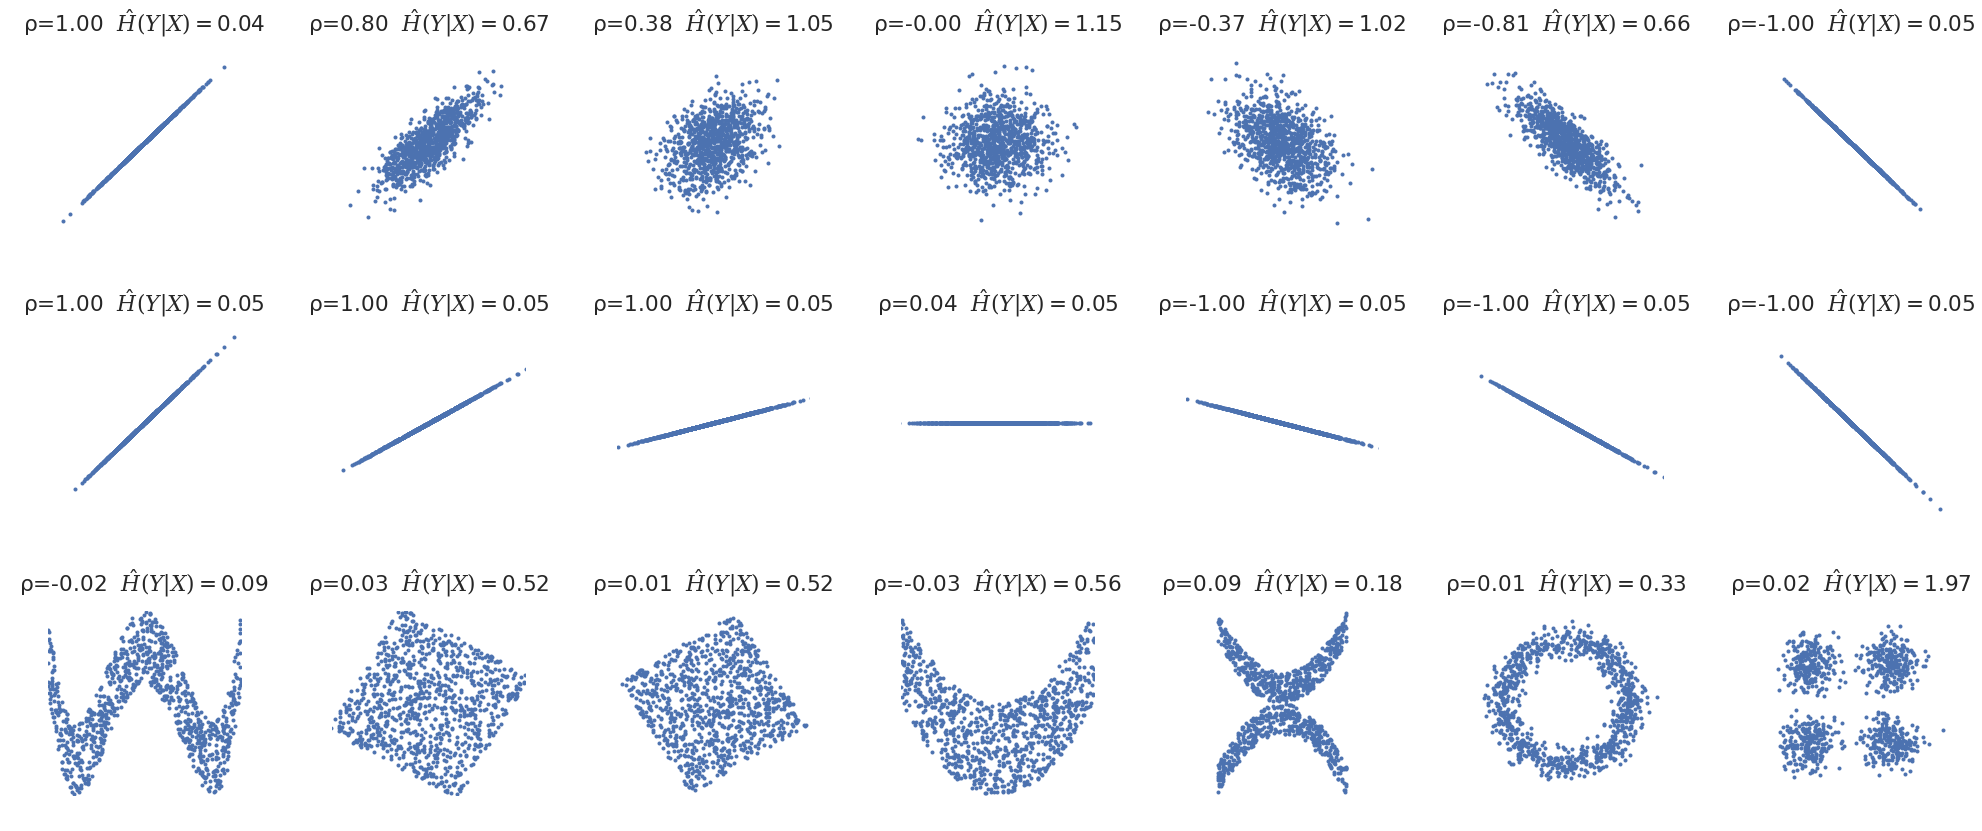

In [47]:
import seaborn as sns
from tqdm import tqdm_notebook
sns.set(font_scale = 1.8)
sns.set_style("ticks")
plt.rcParams["font.family"] = "dejavuserif"
plt.rcParams['mathtext.fontset'] = "dejavuserif"
plt.rcParams['axes.titlepad'] = 20 

f, axar = plt.subplots(3, 7, figsize=(28, 12))
rhos = [1, 0.8, 0.4, 0, -0.4, -0.8, -1]
lim = math.sqrt(2+ math.sqrt(2))/math.sqrt(2)
x_ranges = ([-1, 1], [-lim, lim], [-math.sqrt(2), math.sqrt(2)], [-1, 1], [-1.5, 1.5], [-1.5, 1.5], [-7, 7])
y_ranges = ([-1/3, 1 + 1/3], [-lim, lim], [-math.sqrt(2), math.sqrt(2)], [-1, 3], [-1.5, 1.5], [-1.5, 1.5], [-7, 7])
for j in range(7):
    data = gen_correlated_sample(rho = rhos[j], n = 1000)
    axar[0, j].set_title(u"\u03C1=" + corr_corr_f[j] + r"  $\hat H(Y|X)=$" + corr_cond_entropies_f[j])
    axar[0, j].scatter(data[0], data[1], marker = ".", color = "b")
    axar[0, j].axis('off')
    axar[0, j].set_xlim([-4, 4])
    axar[0, j].set_ylim([-4, 4])

angles = [0, -math.pi/12, -math.pi/6, -math.pi/4, -math.pi/2+math.pi/6, -math.pi/2+math.pi/12, -math.pi/2]
data = gen_correlated_sample(rho = 1., n = 1000)
for j in range(7):
    data_rot = rotate_data(data, angle = angles[j])
    axar[1, j].set_title(u"\u03C1=" + rot_corr_f[j] + r"  $\hat H(Y|X)=$" + rot_cond_entropies_f[j])
    axar[1, j].scatter(data_rot[0], data_rot[1], marker = ".", color = "b")
    axar[1, j].axis('off')
    axar[1, j].set_xlim([-4, 4])
    axar[1, j].set_ylim([-4, 4])
for j in range(7):
    
    axar[2, j].set_title(u"\u03C1=" + settings_corr_f[j] + r"  $\hat H(Y|X)=$" + settings_cond_entropies_f[j])
    axar[2, j].scatter(settings[j][0], settings[j][1], marker = ".", color = "b")
    axar[2, j].axis('off')
    axar[2, j].set_xlim(x_ranges[j])
    axar[2, j].set_ylim(y_ranges[j])

f.tight_layout()
f.savefig("correlation_plots.png")
f.show()